In [29]:
from IPython.display import display

from pathlib import Path 

from training_raster_clipper.core.models import TrainingConfiguration, TrainingFunctions 

from training_raster_clipper.core.logging import log_info

from training_raster_clipper.core.visualization import (
    plot_rgb_data_array,
    plot_array,
    plot_geodataframe,
)

import matplotlib.pyplot as plt

from pathlib import Path

import geopandas as gpd
import numpy as np
import rioxarray
import xarray as xr
from affine import Affine
from geopandas.geodataframe import GeoDataFrame
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier

from training_raster_clipper.custom_types import (
    BandNameType,
    ClassificationResult,
    ClassifiedSamples,
    FeatureClassNameToId,
    PolygonMask,
    ResolutionType,
)

from geopandas import read_file
from rioxarray import open_rasterio
from rasterio.features import rasterize
import numpy as np
import pandas as pd

xr.set_options(keep_attrs=True)

In [4]:
raster_input_path = Path("D:/Profils/iatraoui/Desktop/Project/S2A_MSIL2A_20230823T104631_N0509_R051_T31TCJ_20230823T170355.SAFE")
polygons_input_path = Path(".").resolve().parent / Path("resources/solution/polygons.geojson")

config = TrainingConfiguration(
    verbose = True,
    show_plots = True, 
    resolution = 60,
    band_names = ("B04", "B03", "B02", "B8A"),
    raster_input_path = raster_input_path,
    polygons_input_path = polygons_input_path,
    csv_output_path = (Path(".").resolve().parent / Path("generated/classified_points.csv")),
    raster_output_path=(Path(".").resolve().parent / Path("generated/sklearn_raster.tiff")),
    implementation_name="eschalk",
)
config


TrainingConfiguration(verbose=True, show_plots=True, resolution=60, band_names=('B04', 'B03', 'B02', 'B8A'), raster_input_path=WindowsPath('D:/Profils/iatraoui/Desktop/Project/S2A_MSIL2A_20230823T104631_N0509_R051_T31TCJ_20230823T170355.SAFE'), polygons_input_path=WindowsPath('D:/Profils/iatraoui/Desktop/Project/training-raster-clipper/resources/solution/polygons.geojson'), csv_output_path=WindowsPath('D:/Profils/iatraoui/Desktop/Project/training-raster-clipper/generated/classified_points.csv'), raster_output_path=WindowsPath('D:/Profils/iatraoui/Desktop/Project/training-raster-clipper/generated/sklearn_raster.tiff'), implementation_name='eschalk')

In [5]:
verbose = config.verbose
show_plots = config.show_plots

resolution = config.resolution
band_names = config.band_names

raster_input_path = config.raster_input_path
polygons_input_path = config.polygons_input_path
csv_output_path = config.csv_output_path
raster_output_path = config.raster_output_path


### (1) Load a GeoJSON file with `geopandas`

In [9]:
def load_feature_polygons(input_path: Path) -> GeoDataFrame:
    # ...  # TODO
    gdf = read_file(input_path)
    gdf = gdf.to_crs(32631)
    return gdf
    # raise NotImplementedError


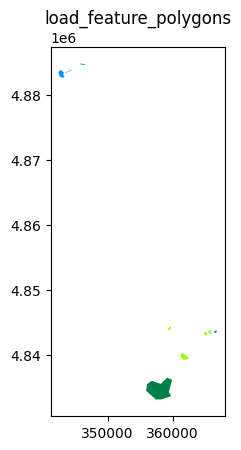

In [11]:
polygons = load_feature_polygons(polygons_input_path)
if verbose:
    log_info(polygons, "polygons")
if show_plots:
    plot_geodataframe(polygons, f"{load_feature_polygons.__name__}")


### (2) Load a Sentinel-2 raster with `rioxarray`

In [12]:
def load_sentinel_data(
    sentinel_product_location: Path,
    resolution: ResolutionType,
    band_names: tuple[BandNameType, ...],
) -> xr.DataArray:
    """Loads sentinel product

    Example input path: `S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE`

    Args:
        sentinel_product_location (Path): Location of the .SAFE folder containing a Sentinel-2 product.

    Returns:
        xr.DataArray: A DataArray containing the 3 RGB bands from the visible spectrum
    """

    paths_list = {
        band_name: list(
            sentinel_product_location.glob(
                f"GRANULE/*/IMG_DATA/R{resolution}m/*_{band_name}_*"
            )
        )[0]
        for band_name in band_names
    }
    data_arrays_list = [
        open_rasterio(paths_list[band_name]).assign_coords({"band": [band_name]})
        for band_name in band_names
    ]
    rasters_data_array = xr.concat(data_arrays_list, dim="band")
    rasters_data_array = rasters_data_array.where(
        rasters_data_array != 0, np.float32(np.nan)
    )
    radio_add_offset = -1000
    quantification_value = 10000
    result = (rasters_data_array + radio_add_offset) / quantification_value
    return result


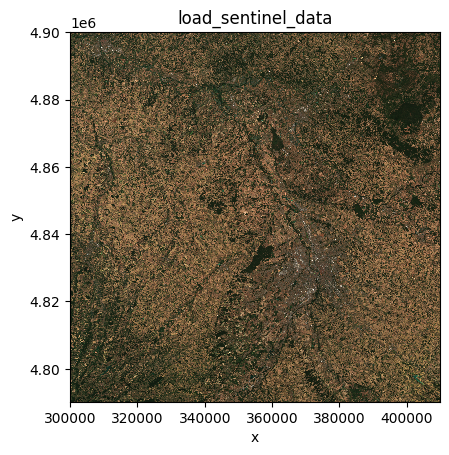

In [13]:
rasters = load_sentinel_data(raster_input_path, resolution, band_names)
if verbose:
    log_info(rasters, "rasters")
if show_plots:
    plot_rgb_data_array(rasters, f"{load_sentinel_data.__name__}")


### (3) Rasterize the polygons

In [53]:
def rasterize_geojson(
    data_array: xr.DataArray,
    training_classes: GeoDataFrame,
) -> tuple[PolygonMask, FeatureClassNameToId]:
    """Burns a set of vectorial polygons to a raster.

    See https://gis.stackexchange.com/questions/316626/rasterio-features-rasterize

    Args:
        data_array (xr.DataArray): The Sentinel raster, from which data is taken, such as the transform or the shape.
        training_classes (GeoDataFrame): The input set of classified multipolygons to burn

    Returns:
        xr.DataArray: A mask raster generated from the polygons, representing the same geographical region as the source dataarray param
                      0 where no polygon were found, and integers representing classes in order of occurence in the GeoDataFrame
    """

    mapping = {
        'WATER' : 1,
        'FOREST' : 2,
        'FARM' : 3
    }

    _, x_shape, y_shape = data_array.shape

    shapes = pd.DataFrame(training_classes)
    shapes = shapes[['geometry', 'class']]
    shapes['class'] = shapes['class'].map(mapping)
    shapes = [tuple(row) for row in shapes.to_numpy()]
    print(shapes[0])

    out_shape = (x_shape, y_shape)

    transform = data_array.spatial_ref.GeoTransform
    transform = [float(x) for x in transform.split()]
    transform = Affine.from_gdal(*transform)

    display(f'{shapes = }')
    display(out_shape)
    display(transform)

    burnt_polygons = rasterize(shapes, out_shape = out_shape, transform = transform)
    
    return (burnt_polygons, mapping)


(<MULTIPOLYGON (((366356.635 4843608.195, 366742.126 4843791.461, 366795.842 ...>, 1)


'shapes = [(<MULTIPOLYGON (((366356.635 4843608.195, 366742.126 4843791.461, 366795.842 ...>, 1), (<MULTIPOLYGON (((355918.751 4834466.232, 357404.208 4833127.367, 358254.436 ...>, 2), (<MULTIPOLYGON (((365718.363 4843753.544, 365876.351 4843791.461, 365967.985 ...>, 3)]'

(1830, 1830)

Affine(60.0, 0.0, 300000.0,
       0.0, -60.0, 4900020.0)

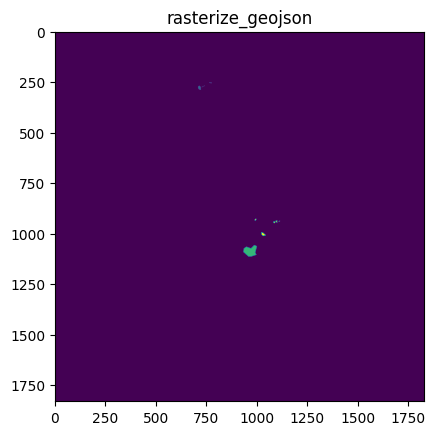

In [54]:
burnt_polygons, mapping = rasterize_geojson(rasters, polygons)
if verbose:
    log_info(burnt_polygons, "burnt_polygons")
    log_info(mapping, "mapping")
if show_plots:
    plot_array(burnt_polygons, f"{rasterize_geojson.__name__}")


### (4) Intersect the Sentinel-2 raster with polygons

In [178]:
def produce_clips(
    data_array: xr.DataArray, burnt_polygons: PolygonMask, mapping: FeatureClassNameToId
) -> ClassifiedSamples:
    """Extract RGB values covered by classified polygons

    Args:
        data_array (xr.DataArray): RGB raster
        burnt_polygons (PolygonMask): Rasterized classified multipolygons

    Returns:
        _type_: A list of the RGB values contained in the data_array and their corresponding classes
    """

    data_array = data_array.stack(z = ('x', 'y'))
    burnt_polygons = burnt_polygons.reshape(1830**2)
    burnt_polygons = burnt_polygons.astype('int64')

    classified_rgb_rows = xr.Dataset(
         {
             "reflectance": (
                 ("band", "z"),
                 data_array.data,
             ),
             "feature_id": (("z"), burnt_polygons),
         },
         coords={"band": ['B04', 'B03', 'B02', 'B8A']},
     )

    classified_rgb_rows = classified_rgb_rows.sel(z = classified_rgb_rows['feature_id'] != 0)
    print(np.unique(classified_rgb_rows['feature_id']))
    print(classified_rgb_rows)


In [179]:
classified_rgb_rows = produce_clips(rasters, burnt_polygons, mapping)
if verbose:
    log_info(classified_rgb_rows, "classified_rgb_rows")


[1 2 3]
<xarray.Dataset>
Dimensions:      (band: 4, z: 3113)
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B8A'
Dimensions without coordinates: z
Data variables:
    reflectance  (band, z) float32 0.2383 0.2223 0.2533 ... 0.3434 0.2657 0.1846
    feature_id   (z) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2 2


### (5) Persist the intersection to a CSV

In [ ]:
def persist_to_csv(
    classified_rgb_rows: ClassifiedSamples,
    csv_output_path: Path,
) -> None:
    ...  # TODO
    raise NotImplementedError


In [ ]:
persist_to_csv(classified_rgb_rows, csv_output_path)
log_info(f"Written CSV output {csv_output_path}")


### (6) Train a machine learning model

In [ ]:
def classify_sentinel_data(
    rasters: xr.DataArray, classified_rgb_rows: ClassifiedSamples
) -> ClassificationResult:
    ...  # TODO
    raise NotImplementedError


In [ ]:
classification_result = classify_sentinel_data(
    rasters, classified_rgb_rows
)
if verbose:
    log_info(classification_result, "classification_result")
if show_plots:
    plot_array(
        classification_result, f"{classify_sentinel_data.__name__}"
    )


### (7) Export the classification raster result

In [ ]:
def persist_classification_to_raster(
    raster_output_path: Path, classification_result: ClassificationResult
) -> None:
    ...  # TODO
    raise NotImplementedError


In [ ]:
persist_classification_to_raster(
    raster_output_path, classification_result
)
log_info(f"Written Classified Raster to {csv_output_path}")

# --

log_info("Congratulations, you reached the end of the tutorial!")
